# **The code we used to preprocess and crop the training data**

In [ ]:
'''
import os
import cv2

# Load the pre-trained face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Input folder containing the images
input_folder = "C:/Users/hp/OneDrive/Desktop/CVA_Data/Timothee_Chalamet/"

# Output folder to save cropped faces
output_folder = "C:/Users/hp/OneDrive/Desktop/CVA_Data/Timothee_Faces_Cropped/"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate over each image file in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust file extensions as needed
        # Load the image
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)

        # Check if the image was loaded successfully
        if image is None:
            print(f"Error: Unable to read {filename}")
            continue

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Crop and save each detected face
        for i, (x, y, w, h) in enumerate(faces):
            face = image[y:y+h, x:x+w]
            output_path = os.path.join(output_folder, f'{filename}_face_{i}.jpg')
            cv2.imwrite(output_path, face)
            '''

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
'''from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

# Authenticate and create the PyDrive client
gauth = GoogleAuth()
gauth.LocalWebserverAuth()  # Opens a new window/tab for authentication
drive = GoogleDrive(gauth)

# ID of the folder containing the images (CroppedFaces folder)
folder_id = 'your_folder_id_here'

# List all files in the folder
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# Download each file
for file in file_list:
    file.GetContentFile(file['title'])  # Download the file and save it in the current directory
    print(f"Downloaded: {file['title']}")'''

In [5]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


# **Without LOOCV**

In [6]:
from google.colab import drive
import os
import cv2
import streamlit as st
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

drive.mount('/content/gdrive')

def load_images_from_subfolder(folder, target_size=(100, 100)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        if img is not None:
            img = cv2.resize(img, target_size)  # Resize the image to a fixed size
            images.append(img)
    return images

def load_images_from_folder(main_folder):
    images = []
    labels = []
    for root, dirs, files in os.walk(main_folder):
        for dir_name in dirs:
            folder_path = os.path.join(root, dir_name)
            celebrity_images = load_images_from_subfolder(folder_path)
            images.extend(celebrity_images)
            labels.extend([dir_name] * len(celebrity_images))  # Assign label based on folder name
    return images, labels

main_folder = '/content/gdrive/MyDrive/CroppedFaces'

images = []
labels = []
for root, dirs, files in os.walk(main_folder):
    for dir_name in dirs:
        folder_path = os.path.join(root, dir_name)
        celebrity_images = load_images_from_subfolder(folder_path)
        images.extend(celebrity_images)
        labels.extend([dir_name] * len(celebrity_images))  # Assign label based on folder name

images = np.array(images)
labels = np.array(labels)

images_flattened = images.reshape(len(images), -1)

X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.2, random_state=42)

clf = svm.SVC(kernel='linear')

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Accuracy: 70.13%


# **LOOCV**

In [7]:
from google.colab import drive
import os
import cv2
import numpy as np
from sklearn import svm
from sklearn.model_selection import LeaveOneOut

drive.mount('/content/gdrive')

def load_images_from_subfolder(folder, target_size=(100, 100)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        if img is not None:
            img = cv2.resize(img, target_size)  # Resize the image to a fixed size
            images.append(img)
    return images

def load_images_from_folder(main_folder):
    images = []
    labels = []
    for root, dirs, files in os.walk(main_folder):
        for dir_name in dirs:
            folder_path = os.path.join(root, dir_name)
            celebrity_images = load_images_from_subfolder(folder_path)
            images.extend(celebrity_images)
            labels.extend([dir_name] * len(celebrity_images))  # Assign label based on folder name
    return images, labels

main_folder = '/content/gdrive/MyDrive/CroppedFaces'

images = []
labels = []
for root, dirs, files in os.walk(main_folder):
    for dir_name in dirs:
        folder_path = os.path.join(root, dir_name)
        celebrity_images = load_images_from_subfolder(folder_path)
        images.extend(celebrity_images)
        labels.extend([dir_name] * len(celebrity_images))  # Assign label based on folder name

images = np.array(images)
labels = np.array(labels)

images_flattened = images.reshape(len(images), -1)

# Perform Leave-One-Out Cross-Validation (LOOCV)
loo = LeaveOneOut()
accuracies = []
c = 1
for train_index, test_index in loo.split(images_flattened):
    c+=1
    X_train, X_test = images_flattened[train_index], images_flattened[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Train the model on the training set
    clf = svm.SVC(kernel='linear')
    clf.fit(X_train, y_train)

    # Evaluate the model on the test set
    accuracy = clf.score(X_test, y_test)
    accuracies.append(accuracy)
    print(c)
# Calculate the mean accuracy across all iterations
mean_accuracy = np.mean(accuracies)
print(f"Mean Accuracy using Leave-One-Out Cross-Validation: {mean_accuracy * 100:.2f}%")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245

In [9]:
# Save the trained model to Google Drive
from joblib import dump
model_save_path = '/content/gdrive/MyDrive/trained_model.joblib'
dump(clf, model_save_path)
print("Model saved successfully to Google Drive.")

Model saved successfully to Google Drive.


# **Testing**

# **Saving the model**

In [10]:
from google.colab import drive
import joblib
drive.mount('/content/gdrive')
model_save_path = '/content/gdrive/MyDrive/trained_model.joblib'
clf = joblib.load(model_save_path)
print("Model loaded successfully from Google Drive.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Model loaded successfully from Google Drive.


Saving AS.png to AS.png
Classifying face 1:
Probability of Dwayne: 0.02
Probability of Timothee: 0.67
Probability of Henry: 0.07
Probability of Ryan: 0.24
This looks like Timothee the most!



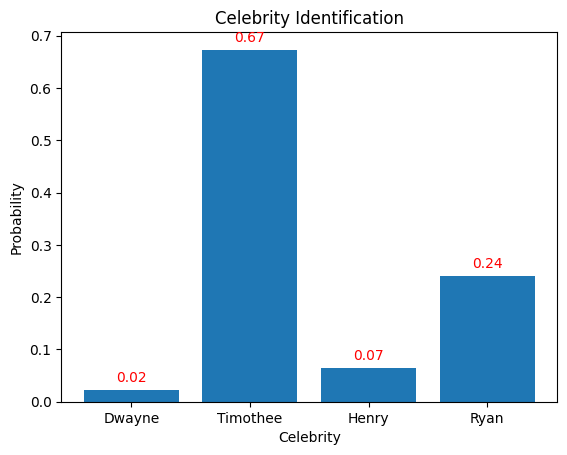

In [11]:
from google.colab import files
import cv2
import numpy as np
import pickle
def preprocess_image(img, target_size=(100, 100)):
    img_resized = cv2.resize(img, target_size)
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    return img_gray

def crop_faces(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    cropped_faces = []
    for (x, y, w, h) in faces:
        cropped_faces.append(image[y:y+h, x:x+w])
    return cropped_faces

def classify_image(image):
    processed_image = preprocess_image(image)
    flattened_image = processed_image.flatten().reshape(1, -1)
    predicted_label = clf.predict(flattened_image)
    decision_values = clf.decision_function(flattened_image)
    probabilities = np.exp(decision_values) / np.sum(np.exp(decision_values), axis=1, keepdims=True)
    return predicted_label[0], probabilities[0]

uploaded_files = files.upload()

file_name = list(uploaded_files.keys())[0]
uploaded_image = cv2.imread(file_name)

cropped_faces = crop_faces(uploaded_image)

for i, face in enumerate(cropped_faces):
    print(f"Classifying face {i + 1}:")
    predicted_celebrity, probability_distribution = classify_image(face)
    celebrity_names = {
        0: "Dwayne",
        1: "Timothee",
        2: "Henry",
        3: "Ryan"
    }
    for i, prob in enumerate(probability_distribution):
        celebrity_name = celebrity_names[i]
        print(f"Probability of {celebrity_name}: {prob:.2f}")

    max_probability_index = np.argmax(probability_distribution)
    max_probability_celebrity = celebrity_names[max_probability_index]

    print(f"This looks like {max_probability_celebrity} the most!\n")




import matplotlib.pyplot as plt

plt.bar(celebrity_names.values(), probability_distribution)

for i, prob in enumerate(probability_distribution):
    plt.text(i, prob + 0.01, f"{prob:.2f}", ha='center', va='bottom', color='red')

plt.title("Celebrity Identification")
plt.xlabel("Celebrity")
plt.ylabel("Probability")

plt.show()


<IPython.core.display.Javascript object>

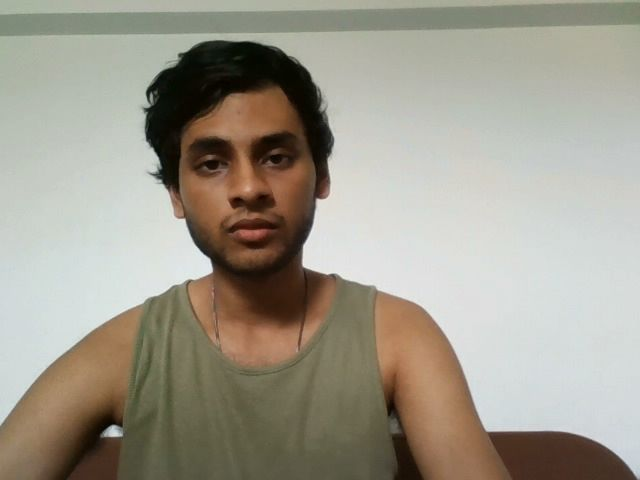

In [12]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Take a photo using the webcam
image_path = take_photo()

# Read the captured image using OpenCV
image = cv2.imread(image_path)

# Display the captured image
cv2_imshow(image)


<IPython.core.display.Javascript object>

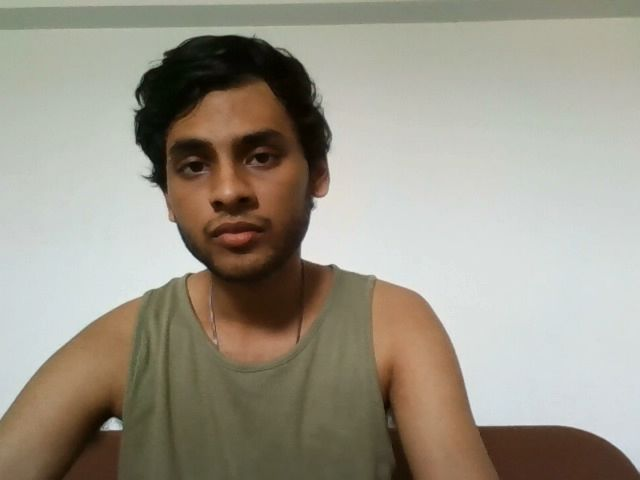

Image saved as: /content/image.jpg


In [13]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2
import os

def take_photo(quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    return binary

# Take a photo using the webcam
image_data = take_photo()

# Decode the image data
image_np = np.frombuffer(image_data, np.uint8)
image = cv2.imdecode(image_np, cv2.IMREAD_COLOR)

# Save the captured image as "image.jpg"
image_file_path = '/content/image.jpg'
cv2.imwrite(image_file_path, image)

# Display the captured image
cv2_imshow(image)

# Print the file path where the image is saved
print("Image saved as:", image_file_path)


Classifying face 1:
Probability of Dwayne: 0.06
Probability of Timothee: 0.25
Probability of Henry: 0.02
Probability of Ryan: 0.68
This looks like Ryan the most!



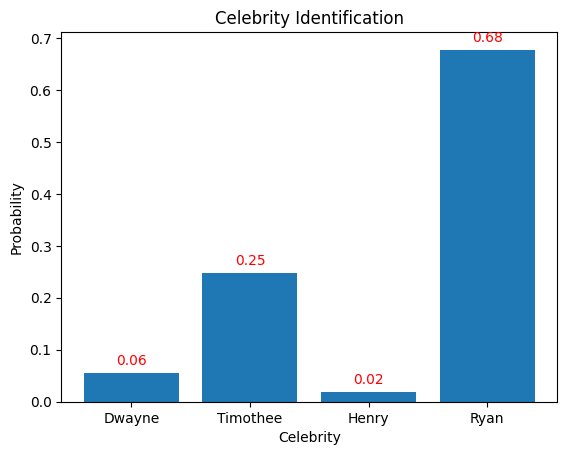

In [14]:
import cv2
import numpy as np
import pickle

def preprocess_image(img, target_size=(100, 100)):
    img_resized = cv2.resize(img, target_size)
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    return img_gray

def crop_faces(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    cropped_faces = []
    for (x, y, w, h) in faces:
        cropped_faces.append(image[y:y+h, x:x+w])
    return cropped_faces

def classify_image(image):
    processed_image = preprocess_image(image)
    flattened_image = processed_image.flatten().reshape(1, -1)
    predicted_label = clf.predict(flattened_image)
    decision_values = clf.decision_function(flattened_image)
    probabilities = np.exp(decision_values) / np.sum(np.exp(decision_values), axis=1, keepdims=True)
    return predicted_label[0], probabilities[0]

# Load the image
image_path = '/content/image.jpg'
uploaded_image = cv2.imread(image_path)

# Crop faces from the uploaded image
cropped_faces = crop_faces(uploaded_image)

# Classify each face in the uploaded image
for i, face in enumerate(cropped_faces):
    print(f"Classifying face {i + 1}:")
    predicted_celebrity, probability_distribution = classify_image(face)
    celebrity_names = {
        0: "Dwayne",
        1: "Timothee",
        2: "Henry",
        3: "Ryan"
    }
    for i, prob in enumerate(probability_distribution):
        celebrity_name = celebrity_names[i]
        print(f"Probability of {celebrity_name}: {prob:.2f}")

    max_probability_index = np.argmax(probability_distribution)
    max_probability_celebrity = celebrity_names[max_probability_index]

    print(f"This looks like {max_probability_celebrity} the most!\n")

import matplotlib.pyplot as plt

plt.bar(celebrity_names.values(), probability_distribution)

for i, prob in enumerate(probability_distribution):
    plt.text(i, prob + 0.01, f"{prob:.2f}", ha='center', va='bottom', color='red')

plt.title("Celebrity Identification")
plt.xlabel("Celebrity")
plt.ylabel("Probability")

plt.show()


In [15]:
st.pyplot(plt)

2024-04-04 10:10:51.759 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


DeltaGenerator()